## Load the data and ignore the warnings

In [88]:
import sys
import pandas as pd
import csv

# Increase CSV field size limit
csv.field_size_limit(sys.maxsize)
# Reload with safe options
df = pd.read_csv('combined_raw_dataset.csv', engine='python', on_bad_lines='skip')

In [89]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124130 entries, 0 to 124129
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Message        124130 non-null  object
 1   label          124130 non-null  int64 
 2   Clean_Message  124094 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,Message,label,Clean_Message
0,\n\nStart Date: 10/13/01; HourAhead hour: 22; ...,0,start date: 10/13/01 hourahead hour: 22 ancill...
1,---------------------- Forwarded by Vince J Ka...,0,forwarded vince kaminski/hou/ect 03/27/2000 20...
2,\n [IMAGE] Webcast June 14th @ 2:00...,0,image webcast june 14th @ 2:00pm edt click reg...
3,\n\n -----Original Message-----\nFrom: =09Dupo...,0,original message from: 09dupont anita 20 sent:...
4,"Jeff--please change my name to ""mike d. smith""...",0,jeffplease change name mike smith thanks forwa...


In [90]:
df['label'].value_counts(dropna=False)

,count
label,
0,114134
1,9996


In [91]:
# Show labels that are not exactly 0 or 1
df[~df['label'].astype(str).isin(['0', '1'])]['label'].unique()

array([], dtype=int64)

In [92]:
# Add 'source' column for visualizations
df['source'] = df['label'].apply(lambda x: 'phish' if x == 1 else 'benign')
df['source'].value_counts()

,count
source,
benign,114134
phish,9996


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Feature 1: 'has_html'

In [94]:
import re

def contains_html(text):
    if pd.isnull(text):
        return 0
    return 1 if re.search(r'<.*?>', text) else 0


df['has_html'] = df['Message'].apply(contains_html)
df['has_html'].value_counts()

,count
has_html,
0,103453
1,20677


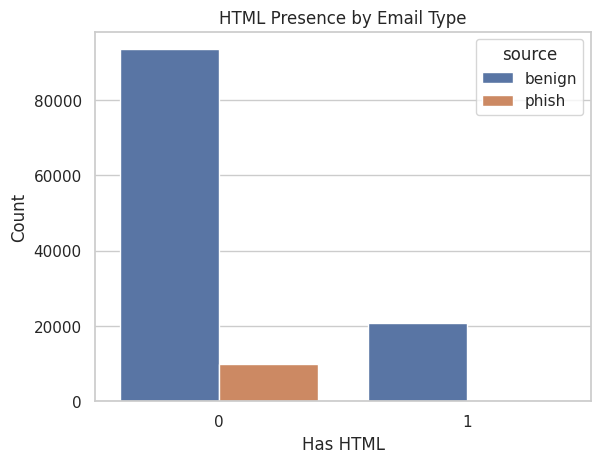

In [95]:
sns.countplot(x='has_html', hue='source', data=df)
plt.title("HTML Presence by Email Type")
plt.xlabel("Has HTML")
plt.ylabel("Count")
plt.show()

In [96]:
html_label_counts = df.groupby(['has_html', 'label']).size().unstack(fill_value=0)

html_label_counts.columns = ['Benign (label=0)', 'Phishing (label=1)']
html_label_counts.index = ['Without HTML (has_html=0)', 'With HTML (has_html=1)']

print(html_label_counts)

                           Benign (label=0)  Phishing (label=1)
Without HTML (has_html=0)             93457                9996
With HTML (has_html=1)                20677                   0


### Insight:
HTML content appears to be a strong negative indicator for phishing in this dataset.

If an email contains HTML, it is very likely to be benign.

If an email is phishing, it is always plain-text (no HTML) in this dataset.

## Feature 2: link count

In [97]:
def count_links(text):
    if pd.isnull(text):
        return 0
    return len(re.findall(r'http[s]?://[^\s<>"]+|www\.[^\s<>"]+', text))


df['link_count'] = df['Message'].apply(count_links)
df['link_count'].describe()


,link_count
count,124130.000000
mean,0.706405
std,5.315408
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,539.000000


### Insights:
1. Most emails (≥75%) have no links.

2. But a few have a lot, which brings the average up.

3. Phishing emails are likely hiding in those outliers.

In [98]:
df.groupby('has_html')['link_count'].mean()

,link_count
has_html,
0,0.407654
1,2.201141


### Insight:
HTML emails are ~5x more likely to contain links than plain-text ones.

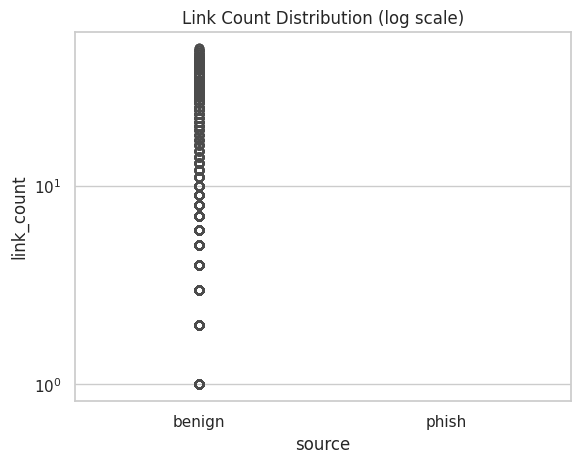

In [99]:
# Filter out outliers for visualization clarity
df_viz = df[df['link_count'] < 50]
sns.boxplot(x='source', y='link_count', data=df_viz)

plt.yscale('log')
plt.title("Link Count Distribution (log scale)")
plt.show()

### Insights:

1. **Most emails contain no hyperlinks** — the median and 75th percentile of `link_count` are both 0.
2. **A small number of emails have many links**, with a maximum of 539. These are rare but extreme.
3. **Emails that contain HTML tend to have more links** (average of 2.18) compared to plain-text emails (average of 0.41).
4. **Boxplot shows some benign emails may contain more links**, but we need to wait for label-wise analysis to confirm which class tends to embed more links consistently.


## Feature 3: shannon_entropy

###  What is it?

**Shannon entropy** measures the **randomness** or **information density** in a text. It’s calculated based on the distribution of characters.

---

###  Why is it useful for phishing?

Phishing and spam messages often:

* Contain **obfuscated text** (random strings, gibberish)
* Hide malicious intent using **encoded text** (e.g., base64 or hex payloads)
* Have **higher entropy** than normal human-written messages

Benign messages, like regular reports or human emails, tend to have **lower entropy** (repetitive, structured).

---

###  How is it calculated?

The formula is:

$$
H = -\sum_{i} p_i \log_2 p_i
$$

Where:

* $p_i$ is the probability of character $i$
* We sum over all unique characters in the string



In [100]:
import math
from collections import Counter

def shannon_entropy(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text) == 0:
        return 0
    counts = Counter(text)
    total = len(text)
    entropy = -sum((count/total) * math.log2(count/total) for count in counts.values())
    return entropy

df['entropy'] = df['Clean_Message'].apply(shannon_entropy)
# Check basic stats
df['entropy'].describe()


,entropy
count,124130.000000
mean,4.298895
std,0.285957
min,0.000000
25%,4.203916
50%,4.346695
75%,4.458292
max,5.194621


In [101]:
df.groupby('source')['entropy'].mean()

,entropy
source,
benign,4.292993
phish,4.366286


### Insight:
High entropy → more randomness → possibly phishing.


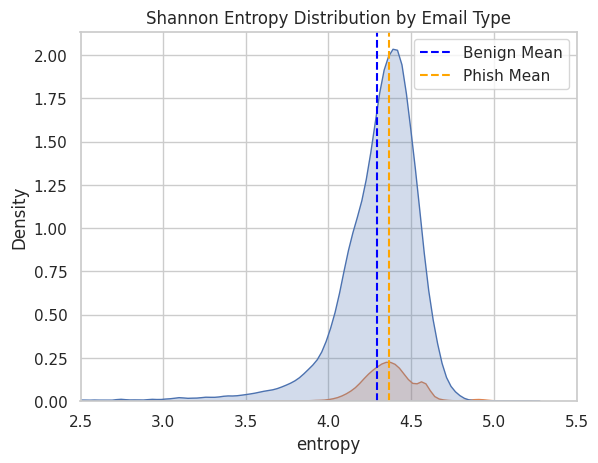

In [102]:
mean_values = df.groupby('source')['entropy'].mean()

sns.kdeplot(data=df, x='entropy', hue='source', fill=True)
plt.axvline(mean_values['benign'], color='blue', linestyle='--', label='Benign Mean')
plt.axvline(mean_values['phish'], color='orange', linestyle='--', label='Phish Mean')
plt.xlim(2.5, 5.5)
plt.title("Shannon Entropy Distribution by Email Type")
plt.legend()
plt.show()


### Insight:
Phishing emails exhibit slightly higher entropy than benign emails. This suggests that phishing messages tend to contain more randomized, obfuscated, or encoded content, which may help attackers evade detection.

## Feature 4: Urgency Keyword Score

In [103]:
# Strong urgency - usually associated with phishing
strong_urgency = [
    'urgent', 'immediately', 'action required', 'verify your account',
    'account suspended', 'update account', 'security alert',
    'confirm your identity', 'reset your password', 'limited time',
    'unauthorized access', 'unusual activity'
]

# Neutral urgency - commonly seen in benign alerts or notifications
neutral_urgency = [
    'click', 'login', 'update', 'respond', 'access',
    'alert', 'notice', 'information', 'submit',
    'deadline', 'due', 'reminder', 'verify'
]

# Weak/general verbs - may appear frequently but not always urgent
weak_urgency = [
    'now', 'here', 'available', 'check', 'follow',
    'help', 'support', 'assist', 'contact'
]


def compute_weighted_urgency_score(text):
    if pd.isnull(text) or not isinstance(text, str):
        return 0
    text = text.lower()

    score = 0
    # Count with weights
    score += sum(text.count(word) * 8 for word in strong_urgency)
    score += sum(text.count(word) * 2 for word in neutral_urgency)
    score += sum(text.count(word) * 0.5 for word in weak_urgency)

    return score

def contains_urgency_keywords(text):
    if pd.isnull(text) or not isinstance(text, str):
        return 0
    text = text.lower()
    all_keywords = strong_urgency + neutral_urgency + weak_urgency
    return int(any(word in text for word in all_keywords))



In [104]:
df['urgency_score'] = df['Clean_Message'].apply(compute_weighted_urgency_score)
df['has_urgency_keyword'] = df['Clean_Message'].apply(contains_urgency_keywords)

# Cap extreme urgency scores (to reduce impact of marketing templates)
upper_clip = df['urgency_score'].quantile(0.95)
df['urgency_score'] = df['urgency_score'].clip(upper=upper_clip)


In [105]:
df.groupby('source')['urgency_score'].mean()

,urgency_score
source,
benign,3.392144
phish,3.664016


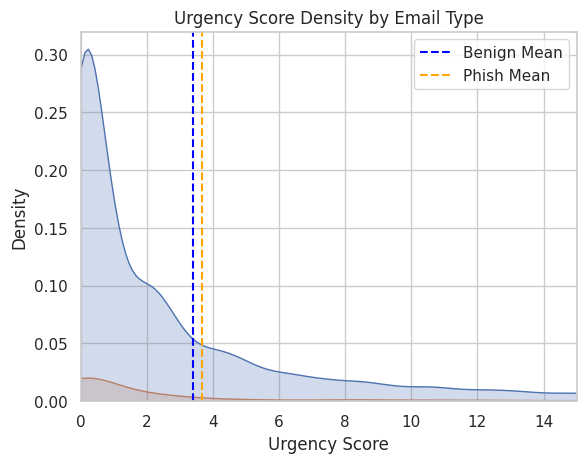

In [106]:
means = df.groupby('source')['urgency_score'].mean()

# Plot KDE with means
sns.kdeplot(data=df, x='urgency_score', hue='source', fill=True)
plt.axvline(means['benign'], color='blue', linestyle='--', label='Benign Mean')
plt.axvline(means['phish'], color='orange', linestyle='--', label='Phish Mean')
plt.legend()
plt.title("Urgency Score Density by Email Type")
plt.xlim(0, 15)
plt.xlabel("Urgency Score")
plt.ylabel("Density")
plt.show()

In [107]:
df.sort_values('urgency_score', ascending=False).head(10)[['Clean_Message', 'urgency_score', 'source']]


,Clean_Message,urgency_score,source
124070,sudiq bawa sudiqbawa9hotmailfr sudiq bawa bill...,17.5,phish
1,forwarded vince kaminski/hou/ect 03/27/2000 20...,17.5,benign
45,can talk about this richard shapiro 07/06/2001...,17.5,benign
9,greetings from amazoncom thought you like know...,17.5,benign
42,company sleuth daily report company sleuth reg...,17.5,benign
88741,power trader tied bush finds washington all ea...,17.5,benign
88738,09image09 09image09image09 image image image i...,17.5,benign
88732,continentalcom specials for john arnold tuesda...,17.5,benign
88726,cnn alerts jacobushcuuykayapologiseto cnn aler...,17.5,phish
8881,sure see before isda signed can double check t...,17.5,benign


### Insights:
Both benign and phishing emails show right-skewed urgency score distributions, with the majority of emails having low urgency.

The mean urgency score is slightly higher for phishing emails (~3.66 vs. ~3.39), but the overlap is large.

Some benign emails also show very high urgency scores, often due to forwarded reports or newsletters containing repeated alert terms.

This suggests that **urgency keywords are not unique to phishing** — their presence alone may not be a strong indicator.

## Feature 5: emotion density

In [108]:
# List of emotional words
emotion_words = [
    'fear', 'panic', 'urgent', 'immediately', 'risk', 'danger', 'suspend', 'failure',
    'reward', 'win', 'free', 'gift', 'lucky', 'congratulations', 'sorry', 'help',
    'violation', 'error', 'unauthorized', 'alert', 'notice', 'warning', 'problem',
    'lost', 'important', 'verify', 'secure', 'threat', 'warn', 'warning', 'warned',
    'account', 'claim', 'update', 'check', 'review', 'issue', 'unable'
]

def emotion_density(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)  # better tokenization
    if not words:
        return 0
    count = sum(word in emotion_words for word in words)
    return count / len(words)

df['emotion_density'] = df['Clean_Message'].apply(emotion_density)
df['emotion_density'].describe()

,emotion_density
count,124130.000000
mean,0.008627
std,0.020737
min,0.000000
25%,0.000000
50%,0.000000
75%,0.010638
max,1.000000


In [109]:
df.groupby('source')['emotion_density'].mean()

,emotion_density
source,
benign,0.007966
phish,0.016175


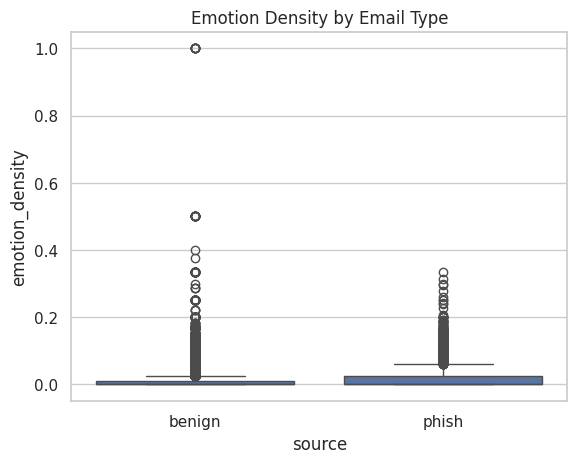

In [110]:
sns.boxplot(x='source', y='emotion_density', data=df)
plt.title("Emotion Density by Email Type")
plt.show()

### Insight:
Phishing emails often use emotionally manipulative language.

## Feature 6:character/word counts

In [111]:
import numpy as np

# Character count (includes punctuation, spacing)
df['char_count'] = df['Clean_Message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

df['word_count'] = df['Clean_Message'].apply(
    lambda x: len(re.findall(r'\b\w+\b', str(x))) if pd.notnull(x) else 0
)

# Log-transformed versions for visualization or ML models
df['log_char_count'] = np.log1p(df['char_count'])
df['log_word_count'] = np.log1p(df['word_count'])

# Average word length
df['avg_word_len'] = df.apply(
    lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0,
    axis=1
)


In [112]:
df[['char_count', 'word_count', 'avg_word_len']].describe()
df.groupby('source')[['char_count', 'word_count', 'avg_word_len']].mean()


,char_count,word_count,avg_word_len
source,,,
benign,1476.371169,220.716167,6.441904
phish,1023.878852,115.375050,7.973637


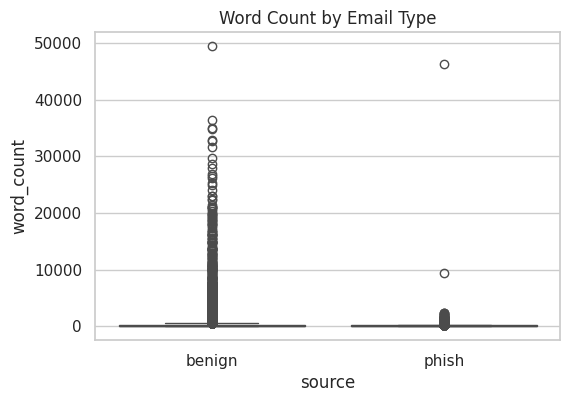

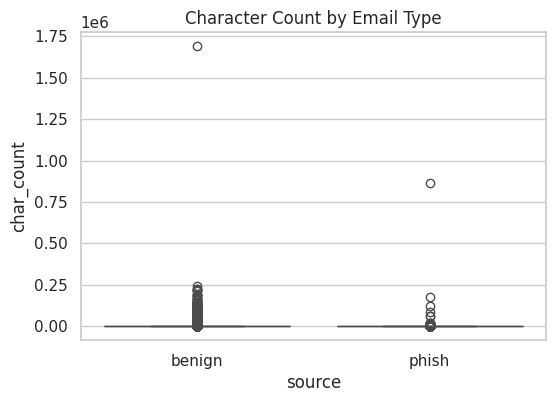

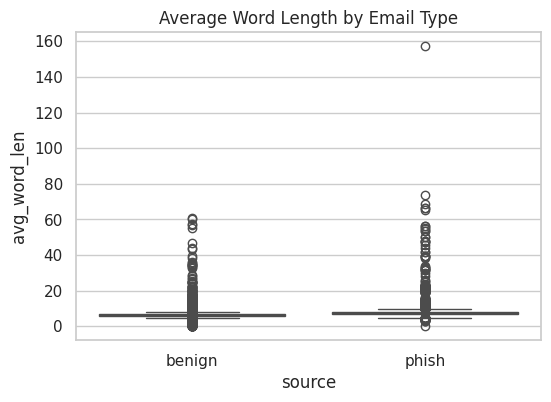

In [113]:
# Boxplot: Word count
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='source', y='word_count')
plt.title("Word Count by Email Type")
plt.show()

# Boxplot: Character count
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='source', y='char_count')
plt.title("Character Count by Email Type")
plt.show()

# Boxplot: Average word length
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='source', y='avg_word_len')
plt.title("Average Word Length by Email Type")
plt.show()


## Feature Correlation Heatmap

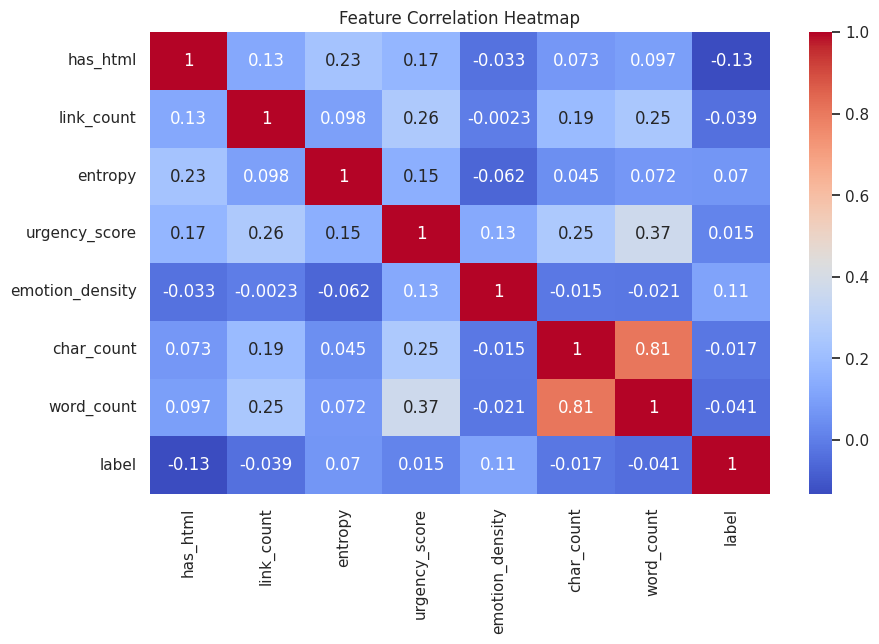

In [114]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['has_html', 'link_count', 'entropy', 'urgency_score', 'emotion_density', 'char_count', 'word_count', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Most Common Words(keywords)

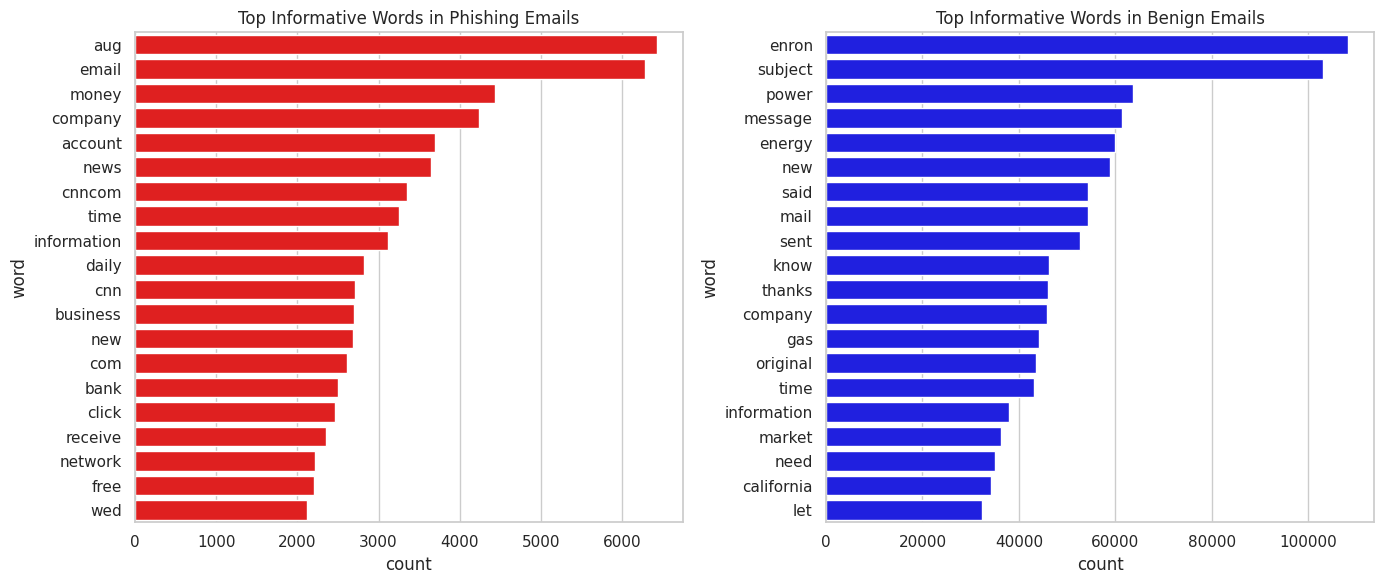

In [115]:
import string
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Function to clean, tokenize, and count words
def get_top_clean_words(texts, n=20):
    stop_words = set(ENGLISH_STOP_WORDS)
    all_text = ' '.join(texts.dropna().astype(str)).lower()
    # Remove punctuation and digits
    all_text = all_text.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = all_text.split()
    # Filter out stopwords and meaningless tokens
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    return Counter(filtered_words).most_common(n)

# 2. Extract top words per class
top_phish_clean = get_top_clean_words(df[df['label'] == 1]['Clean_Message'])
top_benign_clean = get_top_clean_words(df[df['label'] == 0]['Clean_Message'])

# 3. Convert to DataFrame for plotting
phish_df_clean = pd.DataFrame(top_phish_clean, columns=['word', 'count'])
benign_df_clean = pd.DataFrame(top_benign_clean, columns=['word', 'count'])

# 4. Plot bar charts
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=phish_df_clean, x='count', y='word', color='red')
plt.title("Top Informative Words in Phishing Emails")

plt.subplot(1, 2, 2)
sns.barplot(data=benign_df_clean, x='count', y='word', color='blue')
plt.title("Top Informative Words in Benign Emails")

plt.tight_layout()
plt.show()

In [116]:
pip install wordcloud


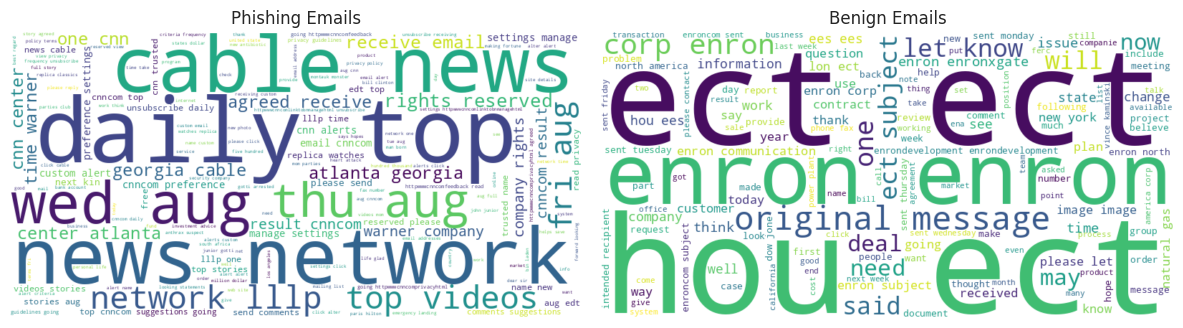

In [117]:
from wordcloud import WordCloud
# Join all words into a single string
phish_text = ' '.join(df[df['label'] == 1]['Clean_Message'].dropna().astype(str))
benign_text = ' '.join(df[df['label'] == 0]['Clean_Message'].dropna().astype(str))

# Generate word clouds
phish_wc = WordCloud(width=800, height=400, background_color='white').generate(phish_text)
benign_wc = WordCloud(width=800, height=400, background_color='white').generate(benign_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(phish_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Emails")

plt.subplot(1, 2, 2)
plt.imshow(benign_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Benign Emails")

plt.tight_layout()
plt.show()


In [118]:
# save
df.to_csv("combined_featured_dataset.csv", index=False)
